In [25]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
import tensorflow as tf
import warnings


from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import AutoModelForMaskedLM
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import get_scheduler
import evaluate
from tqdm.auto import tqdm
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, 
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Ignore Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Load the data
df = pd.read_csv("cleaned data/cleaned_data_split.csv",index_col=0)

In [4]:
# Check cuda status
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [5]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
                  
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Check for missing descriptions

In [6]:
missing_descriptions = df['description'].isna().sum()
print(f"Number of rows with NaN in 'description': {missing_descriptions}")

# Count rows where 'description' is NaN and 'label' is 'human'
num_human = df[df['description'].isna() & (df['account_type'] == 'human')].shape[0]

# Count rows where 'description' is NaN and 'label' is 'bot'
num_bot = df[df['description'].isna() & (df['account_type'] == 'bot')].shape[0]

# Print the results
print(f"Number of rows with NaN 'description' and account_type 'human': {num_human}")
print(f"Number of rows with NaN 'description' and account_type 'bot': {num_bot}")

Number of rows with NaN in 'description': 7257
Number of rows with NaN 'description' and account_type 'human': 0
Number of rows with NaN 'description' and account_type 'bot': 0


### Replace missing descriptions with empty string

In [7]:
# Replace NaN values in 'description' with a placeholder string
df['description'].fillna('unknown', inplace=True)
print(df['description'].isna().sum())

0


### Prepare Dataset

In [8]:
# Convert pandas DataFrame to HuggingFace dataset format
dataset = Dataset.from_pandas(df[['description', 'account_type']].reset_index(drop=True))

train_test_split = dataset.train_test_split(test_size=0.2, seed=42)

### Tokenization

In [9]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["description"], padding="max_length", truncation=True, max_length=64)

# Tokenize the training and testing datasets
tokenized_train = train_test_split['train'].map(tokenize_function, batched=True)
tokenized_test = train_test_split['test'].map(tokenize_function, batched=True)

# Rename columns for consistency
tokenized_train = tokenized_train.rename_column("account_type", "labels")
tokenized_test = tokenized_test.rename_column("account_type", "labels")

# Remove the 'description' column from the tokenized datasets
tokenized_train = tokenized_train.remove_columns(["description"])
tokenized_test = tokenized_test.remove_columns(["description"])

# Set format for PyTorch
tokenized_train.set_format("torch", columns=["labels", "input_ids", "token_type_ids", "attention_mask"])
tokenized_test.set_format("torch", columns=["labels", "input_ids", "token_type_ids", "attention_mask"])

# Create a DatasetDict
tokenized_datasets = DatasetDict({
    "train": tokenized_train,
    "test": tokenized_test
})

# Check the structure of the DatasetDict
print(tokenized_datasets)

Map: 100%|██████████| 7488/7488 [00:00<00:00, 18496.89 examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 29950
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7488
    })
})


Due to training with limited memory, only a part of the dataset (about 10%) is selected.

In [10]:
# Shuffle the dataset with a fixed seed and select a range of examples
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(3000))
eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(300))

### Create DataLoader

In [11]:
batchsize=10
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batchsize)
eval_dataloader = DataLoader(eval_dataset, batch_size=batchsize)

## Model Structure

### Define Model Architecture

In [12]:
class Model(nn.Module):
    def __init__(self,output_dim,dropout_rate):
        super(Model,self).__init__()
        self.encoder=AutoModelForMaskedLM.from_pretrained("bert-base-uncased", output_hidden_states=True, return_dict=True)
        self.dropout=nn.Dropout(dropout_rate)
        # For the "bert-base-uncased" model, each hidden state has a dimension of 768.
        # the value 3072=4*768 corresponds to the total dimension of the concatenated hidden states from the BERT model.
        self.classifier=nn.Linear(3072,output_dim)

    def forward(self,input_ids,token_type_ids,attention_mask):
        outputs = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        # The shape of the resulting tensor is [batch_size, sequence_length, hidden_dim*4].
        hidden_states = torch.cat(tuple([outputs.hidden_states[i] for i in [-1, -2, -3, -4]]), dim=-1)

        x=self.dropout(hidden_states[:, 0, :])
        x=self.classifier(x)
        return x

### Create Model Instance

In [13]:
model = Model(output_dim=2, dropout_rate = 0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fct = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/Users/thiri/Downloads/bt4222/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT s

### Training and Evaluation

In [14]:
epochs = 5
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )
metric = evaluate.load("accuracy")
progress_bar = tqdm(range(num_training_steps))

  0%|          | 0/1500 [00:00<?, ?it/s]

In [15]:
all_true_labels = []
all_predictions = []

for epoch in range(epochs):
        for batch in train_dataloader:
            model.train()
            # Loop through batches in the training data loader
            batch = {k: v.to(device) for k, v in batch.items()}
            label_ids = batch['labels'].long()
            input_ids = batch['input_ids']
            token_type_ids = None
            attention_mask = batch['attention_mask']
            # Perform a forward pass through the model to get logits
            logits = model(input_ids, token_type_ids, attention_mask)

            # Calculate loss
            loss = loss_fct(logits, label_ids.view(-1))
            # Perform backward pass and update model parameters
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            # Update progress bar
            progress_bar.update(1)


        model.eval()
        true_labels = []
        predictions = []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad(): # disable gradient computation
                label_ids = batch['labels'].long()
                input_ids = batch['input_ids']
                token_type_ids = None
                attention_mask = batch['attention_mask']
                logits = model(input_ids, token_type_ids, attention_mask)
                loss = loss_fct(logits, label_ids.view(-1))

            # Get predicted labels by selecting the class with the highest probability
            preds = torch.argmax(logits, dim=-1)
            
            metric.add_batch(predictions=preds, references=batch["labels"])

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label_ids.cpu().numpy())
        
        all_true_labels.extend(true_labels)
        all_predictions.extend(predictions)

        acc = metric.compute()
        print(f'Epoch {epoch+1}')
        print(f'val_loss : {loss}')
        print(25*'==')

 20%|██        | 300/1500 [05:23<22:35,  1.13s/it]

Epoch 1
val_loss : 0.24764013290405273


 40%|████      | 600/1500 [11:32<16:45,  1.12s/it]  

Epoch 2
val_loss : 0.2501984238624573


 60%|██████    | 900/1500 [17:34<12:06,  1.21s/it]  

Epoch 3
val_loss : 0.3067266345024109


 80%|████████  | 1200/1500 [28:04<05:40,  1.14s/it]  

Epoch 4
val_loss : 0.903079628944397


100%|██████████| 1500/1500 [34:02<00:00,  1.16s/it]

Epoch 5
val_loss : 1.0502393245697021


### Performance Metrics

In [16]:
report = classification_report(all_true_labels, all_predictions, target_names=["Not Bot", "Bot"], labels=[0,1])

print("Final Classification Report:\n", report)

Final Classification Report:
               precision    recall  f1-score   support

     Not Bot       0.78      0.82      0.80      1010
         Bot       0.59      0.53      0.56       490

    accuracy                           0.73      1500
   macro avg       0.69      0.68      0.68      1500
weighted avg       0.72      0.73      0.72      1500



In [20]:
accuracy = accuracy_score(all_true_labels, all_predictions)
recall = recall_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions)
f1 = f1_score(all_true_labels, all_predictions)

print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F1-Score:", f1)

Accuracy:  0.728
Recall:  0.5306122448979592
Precision:  0.593607305936073
F1-Score: 0.5603448275862069


### Confusion Matrix

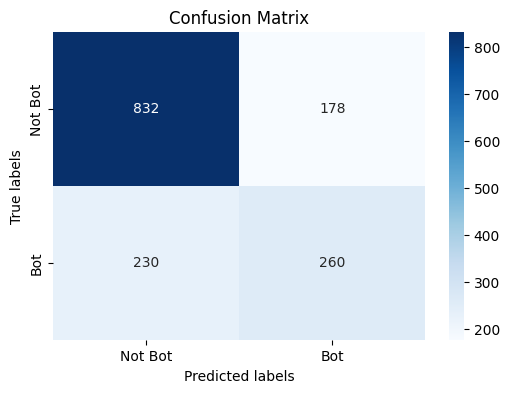

In [18]:
cm = confusion_matrix(all_true_labels, all_predictions)
labels = ["Not Bot", "Bot"]

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Replicability

In [26]:
# Save model
with open("output_files/description_sentiment_analysis_model.pkl", 'wb') as f:
    pickle.dump(model, f)

In [28]:
data = [
    {
        'model': 'Sentiment Analysis on Description',
        'test_metrics': {
            'accuracy': accuracy,
            'recall' : recall,
            'precision' : precision,
            'f1_score' : f1
        }
    }
]
df_results = pd.DataFrame(data)

# Save to CSV
df_results.to_csv('output_files/model_results_description_sentiment_analysis.csv', index=False)